### Spatial Resolution Normalization ###

In [2]:
import os
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Point, mapping, box
from pyproj import Transformer
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [27]:
# --- CONFIGURATION ---
YEAR = 2022
NAIP_FOLDER = f"naip_data/naip_images_{YEAR}"
OUTPUT_FOLDER = f"preprocessed_output_{YEAR}"
INTEREST_POINT_LATLON = (34.4385, c-106.2377)
BUFFER_RADIUS_METERS = 200
TARGET_RESOLUTION = 1.0  # meters

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

In [28]:
# Get coordinate system from first .tif
tif_files = glob(os.path.join(NAIP_FOLDER, "*.tif"))
if not tif_files:
    raise FileNotFoundError(f"No .tif files found in {NAIP_FOLDER}")

with rasterio.open(tif_files[0]) as ref_src:
    crs = ref_src.crs
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    interest_x, interest_y = transformer.transform(INTEREST_POINT_LATLON[1], INTEREST_POINT_LATLON[0])
    buffer_geom = Point(interest_x, interest_y).buffer(BUFFER_RADIUS_METERS)
    buffer_geojson = [mapping(buffer_geom)]

In [29]:
intersecting = []
for path in tif_files:
    with rasterio.open(path) as src:
        bounds = box(*src.bounds)
        if buffer_geom.intersects(bounds):
            intersecting.append(path)

print(f"Found {len(intersecting)} intersecting raster(s) for YEAR={YEAR}")

Found 1 intersecting raster(s) for YEAR=2022


In [30]:
# Merge intersecting rasters
srcs = [rasterio.open(path) for path in intersecting]
merged, merged_transform = merge(srcs)
meta = srcs[0].meta.copy()
meta.update({
    "height": merged.shape[1],
    "width": merged.shape[2],
    "transform": merged_transform
})

# Save temporary merged raster
temp_merged_path = os.path.join(OUTPUT_FOLDER, f"temp_merged_{YEAR}.tif")
with rasterio.open(temp_merged_path, "w", **meta) as temp_dst:
    temp_dst.write(merged)

# Now crop the buffer from the temp merged file
with rasterio.open(temp_merged_path) as temp_src:
    cropped, cropped_transform = mask(temp_src, buffer_geojson, crop=True)
    meta.update({
        "height": cropped.shape[1],
        "width": cropped.shape[2],
        "transform": cropped_transform
    })

    raw_path = os.path.join(OUTPUT_FOLDER, f"raw_buffer_{YEAR}.tif")
    with rasterio.open(raw_path, "w", **meta) as dst:
        dst.write(cropped)

print(f"Saved raw cropped buffer: {raw_path}")

Saved raw cropped buffer: preprocessed_output_2022/raw_buffer_2022.tif


In [31]:
png_img = np.moveaxis(cropped[:3], 0, -1)
png_img = ((png_img - png_img.min()) / (np.ptp(png_img) + 1e-6) * 255).astype(np.uint8)
Image.fromarray(png_img).save(os.path.join(OUTPUT_FOLDER, f"raw_buffer_{YEAR}.png"))

In [32]:
if YEAR > 2016:
    dst_transform, width, height = calculate_default_transform(
        crs, crs, cropped.shape[2], cropped.shape[1],
        *rasterio.transform.array_bounds(cropped.shape[1], cropped.shape[2], cropped_transform),
        resolution=(TARGET_RESOLUTION, TARGET_RESOLUTION)
    )

    coarse_meta = meta.copy()
    coarse_meta.update({
        "height": height,
        "width": width,
        "transform": dst_transform,
        "dtype": 'float32'
    })

    resampled = np.zeros((cropped.shape[0], height, width), dtype=np.float32)
    for i in range(cropped.shape[0]):
        reproject(
            source=cropped[i],
            destination=resampled[i],
            src_transform=cropped_transform,
            src_crs=crs,
            dst_transform=dst_transform,
            dst_crs=crs,
            resampling=Resampling.average
        )

    coarse_path = os.path.join(OUTPUT_FOLDER, f"coarsened_buffer_{YEAR}.tif")
    with rasterio.open(coarse_path, "w", **coarse_meta) as dst:
        dst.write(resampled)
    print(f"Saved coarsened buffer: {coarse_path}")

    png_resampled = np.moveaxis(resampled[:3], 0, -1)
    png_resampled = ((png_resampled - png_resampled.min()) / (np.ptp(png_resampled) + 1e-6) * 255).astype(np.uint8)
    Image.fromarray(png_resampled).save(os.path.join(OUTPUT_FOLDER, f"coarsened_buffer_{YEAR}.png"))

Saved coarsened buffer: preprocessed_output_2022/coarsened_buffer_2022.tif


In [33]:
import os
import rasterio

def inspect_naip_resolution(year, base_folder="preprocessed_output_{}"):
    folder = base_folder.format(year)
    raw_tif = os.path.join(folder, f"raw_buffer_{year}.tif")
    coarse_tif = os.path.join(folder, f"coarsened_buffer_{year}.tif")

    print(f"\n📅 YEAR: {year}")
    
    with rasterio.open(raw_tif) as raw:
        print("RAW:")
        print(f"  Resolution: {raw.res}")
        print(f"  Width x Height: {raw.width} x {raw.height}")
    
    if os.path.exists(coarse_tif):
        with rasterio.open(coarse_tif) as coarse:
            print("COARSENED:")
            print(f"  Resolution: {coarse.res}")
            print(f"  Width x Height: {coarse.width} x {coarse.height}")
    else:
        print("COARSENED: Not available (image likely from 2014 or earlier)")

# Example usage:
for yr in [2014, 2016, 2018, 2020, 2022]:
    inspect_naip_resolution(yr)



📅 YEAR: 2014
RAW:
  Resolution: (1.0, 1.0)
  Width x Height: 401 x 401
COARSENED: Not available (image likely from 2014 or earlier)

📅 YEAR: 2016
RAW:
  Resolution: (1.0, 1.0)
  Width x Height: 401 x 401
COARSENED: Not available (image likely from 2014 or earlier)

📅 YEAR: 2018
RAW:
  Resolution: (0.6, 0.6)
  Width x Height: 668 x 668
COARSENED:
  Resolution: (1.0, 1.0)
  Width x Height: 401 x 401

📅 YEAR: 2020
RAW:
  Resolution: (0.6, 0.6)
  Width x Height: 668 x 668
COARSENED:
  Resolution: (1.0, 1.0)
  Width x Height: 401 x 401

📅 YEAR: 2022
RAW:
  Resolution: (0.6, 0.6)
  Width x Height: 668 x 668
COARSENED:
  Resolution: (1.0, 1.0)
  Width x Height: 401 x 401


In [34]:
import rasterio

def check_bounds(years, base_folder="preprocessed_output_{}"):
    for year in years:
        path = os.path.join(base_folder.format(year), f"coarsened_buffer_{year}.tif")
        if not os.path.exists(path):  # fallback to raw if no coarsened
            path = os.path.join(base_folder.format(year), f"raw_buffer_{year}.tif")
            source = "RAW"
        else:
            source = "COARSENED"

        with rasterio.open(path) as src:
            print(f"📅 YEAR: {year} ({source})")
            print(f"  Bounds: {src.bounds}")
            print(f"  CRS: {src.crs}")
            print()

check_bounds([2014, 2016, 2018, 2020, 2022])

📅 YEAR: 2014 (RAW)
  Bounds: BoundingBox(left=386088.0, bottom=3811272.0, right=386489.0, top=3811673.0)
  CRS: EPSG:26913

📅 YEAR: 2016 (RAW)
  Bounds: BoundingBox(left=386088.0, bottom=3811272.0, right=386489.0, top=3811673.0)
  CRS: EPSG:26913

📅 YEAR: 2018 (COARSENED)
  Bounds: BoundingBox(left=386088.0, bottom=3811271.8, right=386489.0, top=3811672.8)
  CRS: EPSG:26913

📅 YEAR: 2020 (COARSENED)
  Bounds: BoundingBox(left=386088.0, bottom=3811271.8, right=386489.0, top=3811672.8)
  CRS: EPSG:26913

📅 YEAR: 2022 (COARSENED)
  Bounds: BoundingBox(left=386088.0, bottom=3811271.8, right=386489.0, top=3811672.8)
  CRS: EPSG:26913



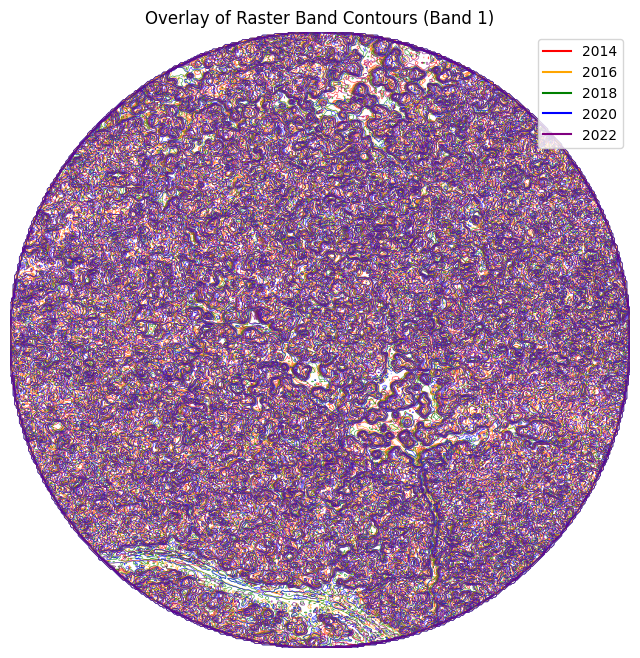

In [3]:
import matplotlib.pyplot as plt

def plot_overlays(years, band=1):
    plt.figure(figsize=(8, 8))
    colors = ['red', 'orange', 'green', 'blue', 'purple']
    for i, year in enumerate(years):
        path = os.path.join(f"preprocessed_output_{year}", 
                            f"coarsened_buffer_{year}.tif" if year > 2016 else f"raw_buffer_{year}.tif")
        with rasterio.open(path) as src:
            data = src.read(band)
            plt.contour(data, linewidths=0.5, alpha=0.7, colors=[colors[i]])
    for i, year in enumerate(years):
        plt.plot([], [], color=colors[i], label=str(year))  # dummy plot for legend
    plt.title("Overlay of Raster Band Contours (Band {})".format(band))
    plt.legend()
    plt.axis('off')
    plt.show()


plot_overlays([2014, 2016, 2018, 2020, 2022])

### Spectral Resolution Normalization ###

In [39]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from skimage.exposure import match_histograms
from PIL import Image

In [40]:
YEARS = [2014, 2016, 2018, 2020, 2022]
BASE_DIR = "preprocessed_output_{}"
FILENAME = lambda year: (
    f"coarsened_buffer_{year}.tif"
    if os.path.exists(os.path.join(BASE_DIR.format(year), f"coarsened_buffer_{year}.tif"))
    else f"raw_buffer_{year}.tif"
)

In [46]:
ref_year = 2020
ref_path = os.path.join(BASE_DIR.format(ref_year), FILENAME(ref_year))
with rasterio.open(ref_path) as ref_src:
    ref_data = ref_src.read()
    ref_bands = [ref_data[i].astype(np.uint16) for i in range(ref_data.shape[0])]

In [47]:
for year in YEARS:
    input_path = os.path.join(BASE_DIR.format(year), FILENAME(year))
    out_dir = BASE_DIR.format(year)

    with rasterio.open(input_path) as src:
        profile = src.profile.copy()

        if tuple(src.res) != (1.0, 1.0):
            raise ValueError(f"{year} has resolution {src.res}, not 1.0m")

        data = src.read()
        matched = np.zeros_like(data, dtype=np.uint16)

        for band_i in range(4):
            matched[band_i] = match_histograms(
                data[band_i].astype(np.uint16),
                ref_bands[band_i],
                channel_axis=None
            )

        # Save matched .tif
        profile.update(dtype=rasterio.uint16)
        tif_path = os.path.join(out_dir, f"matched_buffer_{year}.tif")
        with rasterio.open(tif_path, "w", **profile) as dst:
            dst.write(matched)

        # Save matched .png from RGB bands
        rgb = np.moveaxis(matched[:3], 0, -1)
        rgb_scaled = np.zeros_like(rgb, dtype=np.uint8)
        for i in range(3):
            ch = rgb[:, :, i]
            rgb_scaled[:, :, i] = ((ch - ch.min()) / (np.ptp(ch) + 1e-6) * 255).astype(np.uint8)
        Image.fromarray(rgb_scaled).save(os.path.join(out_dir, f"matched_buffer_{year}.png"))

        print(f"✅ Saved normalized .tif and .png for {year}")

✅ Saved normalized .tif and .png for 2014
✅ Saved normalized .tif and .png for 2016
✅ Saved normalized .tif and .png for 2018
✅ Saved normalized .tif and .png for 2020
✅ Saved normalized .tif and .png for 2022


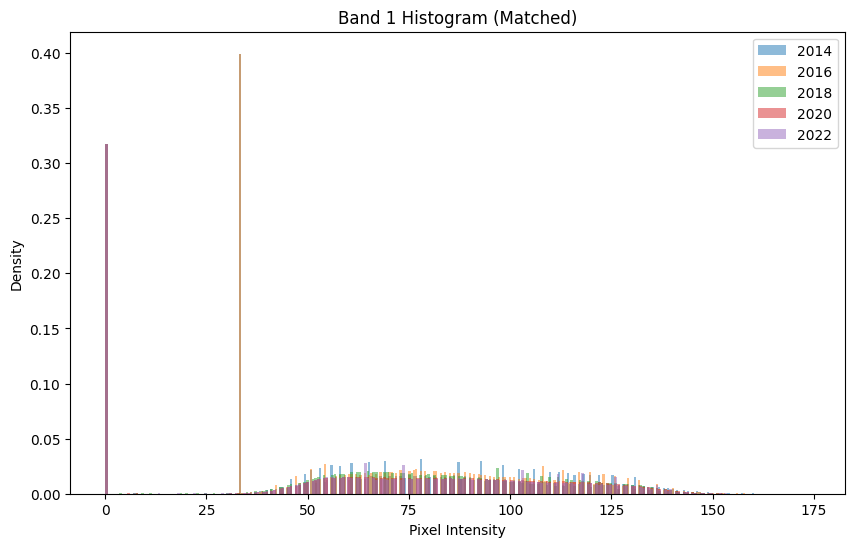

In [49]:
import matplotlib.pyplot as plt

def plot_band_histograms(years, band=0):  # 0 = Red
    plt.figure(figsize=(10, 6))
    for year in years:
        path = os.path.join(f"preprocessed_output_{year}", f"matched_buffer_{year}.tif")
        if not os.path.exists(path):
            print(f"Missing: {year}")
            continue
        with rasterio.open(path) as src:
            band_data = src.read(band + 1).flatten()
            plt.hist(band_data, bins=256, alpha=0.5, label=str(year), density=True)
    plt.title(f"Band {band + 1} Histogram (Matched)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

plot_band_histograms([2014, 2016, 2018, 2020, 2022])

### Labeling Samples Extraction ###

In [3]:
import os
import numpy as np
import rasterio
from PIL import Image
import pandas as pd
import random

YEARS = [2014, 2016, 2018, 2020, 2022]
BASE_DIR = "preprocessed_output_{}"
OUT_DIR = "labeled_samples"
os.makedirs(OUT_DIR, exist_ok=True)

SAMPLES_TARGET = 300
PATCH_SIZE = 5
PATCHES_NEEDED = 50  # 15 patches × ~20 pixels = ~300
NDVI_THRESHOLDS = {
    "live": 0.4,
    "mid": (0.1, 0.4),
    "low": 0.05
}
random.seed(42)

In [4]:
def compute_ndvi(nir, red):
    nir = nir.astype(np.float32)
    red = red.astype(np.float32)
    ndvi = (nir - red) / (nir + red + 1e-6)
    return np.clip(ndvi, -1.0, 1.0)

def save_pixel_png(rgb_bands, path):
    # rgb_bands is a 3-element array (R, G, B) with raw uint16/float values
    rgb = np.clip(rgb_bands, 0, 255).astype(np.uint8)
    Image.fromarray(rgb.reshape(1, 1, 3)).save(path)

In [5]:
ref_year = 2020
ref_path = os.path.join(BASE_DIR.format(ref_year), f"matched_buffer_{ref_year}.tif")
with rasterio.open(ref_path) as ref_src:
    height, width = ref_src.height, ref_src.width
    patch_coords = []

    while len(patch_coords) < PATCHES_NEEDED:
        r = random.randint(0, height - PATCH_SIZE)
        c = random.randint(0, width - PATCH_SIZE)
        patch_coords.append((r, c))

print(f"📌 Selected {len(patch_coords)} patches for sampling.")


📌 Selected 50 patches for sampling.


In [6]:
samples = []
taken_keys = set()
ndvi_map = {}

for r0, c0 in patch_coords:
    with rasterio.open(ref_path) as src:
        patch = src.read(window=((r0, r0+PATCH_SIZE), (c0, c0+PATCH_SIZE)))
        red = patch[0]
        nir = patch[3]
        ndvi_patch = compute_ndvi(nir, red)

        indices = [(i, j) for i in range(PATCH_SIZE) for j in range(PATCH_SIZE)]
        random.shuffle(indices)

        for i, j in indices:
            rr, cc = r0 + i, c0 + j
            key = (rr, cc)
            if key in taken_keys:
                continue

            ndvi = ndvi_patch[i, j]
            if np.isnan(ndvi):
                continue
            if ndvi > NDVI_THRESHOLDS["live"]:
                pass
            elif NDVI_THRESHOLDS["mid"][0] <= ndvi <= NDVI_THRESHOLDS["mid"][1]:
                pass
            elif ndvi > NDVI_THRESHOLDS["low"]:
                pass
            else:
                continue

            samples.append(key)
            taken_keys.add(key)
            ndvi_map[key] = ndvi

            if len(samples) >= SAMPLES_TARGET:
                break
    if len(samples) >= SAMPLES_TARGET:
        break

print(f"✅ Final sample count: {len(samples)} pixels across {len(patch_coords)} patches.")


✅ Final sample count: 300 pixels across 50 patches.


In [98]:
metadata = []

for row, col in samples:
    ndvi = ndvi_map[(row, col)]

    for year in YEARS:
        tif_path = os.path.join(BASE_DIR.format(year), f"matched_buffer_{year}.tif")
        if not os.path.exists(tif_path):
            print(f"⚠️ Skipping {tif_path} (missing)")
            continue

        with rasterio.open(tif_path) as src:
            pixel = src.read(window=((row, row+1), (col, col+1)))  # [bands, 1, 1]
            meta = src.meta.copy()
            meta.update({"height": 1, "width": 1, "transform": None})

            base = f"r{row}_c{col}_y{year}"
            tif_out = os.path.join(OUT_DIR, f"{base}.tif")
            png_out = os.path.join(OUT_DIR, f"{base}.png")

            with rasterio.open(tif_out, "w", **meta) as dst:
                dst.write(pixel)
            save_pixel_png(pixel[:3, 0, 0], png_out)

            if year == 2020:
                ndvi_val = ndvi
                if ndvi_val > 0.4:
                    hint = "possibly LIVE"
                elif 0.1 <= ndvi_val <= 0.4:
                    hint = "possibly BARE or DEAD"
                elif ndvi_val > 0.05:
                    hint = "possibly DEAD"
                else:
                    hint = "unsure"
            else:
                ndvi_val = None
                hint = None

            metadata.append({
                "filename": f"{base}.png",
                "row": row,
                "col": col,
                "year": year,
                "ndvi_2020": ndvi_val,
                "label_hint": hint
            })

df = pd.DataFrame(metadata)
df.to_csv(os.path.join(OUT_DIR, "metadata.csv"), index=False)
print(f"📁 Saved {len(metadata)} labeled samples with hints to: {OUT_DIR}/metadata.csv")

📁 Saved 1500 labeled samples with hints to: labeled_samples/metadata.csv


In [7]:
metadata = []

for row, col in samples:
    for year in YEARS:
        tif_path = os.path.join(BASE_DIR.format(year), f"matched_buffer_{year}.tif")
        if not os.path.exists(tif_path):
            print(f"⚠️ Skipping {tif_path} (missing)")
            continue

        with rasterio.open(tif_path) as src:
            pixel = src.read(window=((row, row+1), (col, col+1)))  # [bands, 1, 1]
            meta = src.meta.copy()
            meta.update({"height": 1, "width": 1, "transform": None})

            base = f"r{row}_c{col}_y{year}"
            tif_out = os.path.join(OUT_DIR, f"{base}.tif")
            png_out = os.path.join(OUT_DIR, f"{base}.png")

            with rasterio.open(tif_out, "w", **meta) as dst:
                dst.write(pixel)
            save_pixel_png(pixel[:3, 0, 0], png_out)

            # Compute NDVI for this year using Band 4 (NIR) and Band 1 (Red)
            nir = pixel[3, 0, 0].astype(np.float32)
            red = pixel[0, 0, 0].astype(np.float32)
            ndvi_val = (nir - red) / (nir + red + 1e-6)
            ndvi_val = float(np.clip(ndvi_val, -1.0, 1.0))

            if ndvi_val >= 0.8:
                label = "LIVE"
            else:
                label = ""

            metadata.append({
                "filename": f"{base}.png",
                "row": row,
                "col": col,
                "year": year,
                "ndvi": ndvi_val,
                "label": label
            })

df = pd.DataFrame(metadata)
df.to_csv(os.path.join(OUT_DIR, "metadata_2.csv"), index=False)
print(f"📁 Saved {len(metadata)} labeled samples with NDVI and labels to: {OUT_DIR}/metadata_2.csv")


/Users/devparagiri/Research/tree-mortality-v3/env/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


📁 Saved 1500 labeled samples with NDVI and labels to: labeled_samples/metadata_2.csv


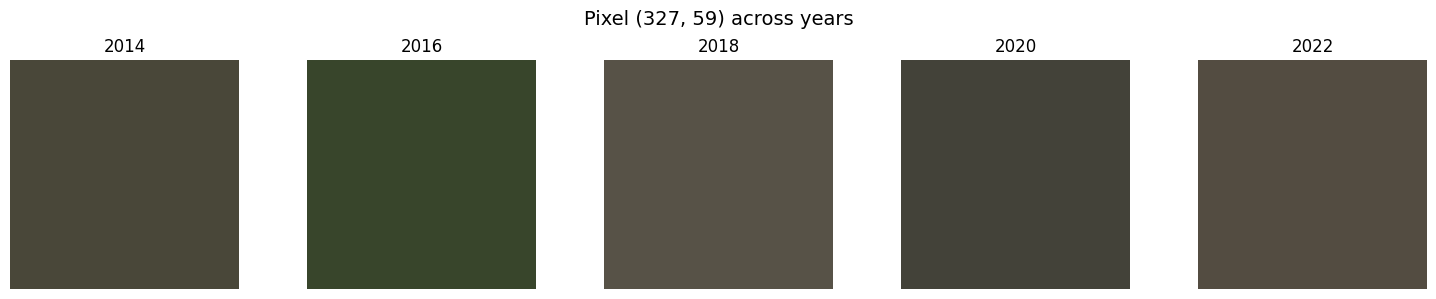

In [60]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Configuration
LABEL_FOLDER = "labeled_samples/"
YEARS = [2014, 2016, 2018, 2020, 2022]

def show_pixel_across_years(row, col):
    fig, axes = plt.subplots(1, len(YEARS), figsize=(15, 3))
    fig.suptitle(f"Pixel ({row}, {col}) across years", fontsize=14)

    for i, year in enumerate(YEARS):
        filename = f"r{row}_c{col}_y{year}.png"
        filepath = os.path.join(LABEL_FOLDER, filename)

        ax = axes[i]
        ax.axis('off')
        ax.set_title(f"{year}")

        if os.path.exists(filepath):
            img = Image.open(filepath)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=10)
            ax.set_facecolor("lightgray")

    plt.tight_layout()
    plt.show()

# Example usage
show_pixel_across_years(row=327, col=59)


### Inspect TIF Bands ###

In [9]:
import rasterio
import numpy as np

def inspect_tif_bands(tif_path):
    band_stats = {}

    try:
        with rasterio.open(tif_path) as src:
            print(f"🗂️  Inspecting {tif_path}")
            print(f"📏 Resolution: {src.res}")
            print(f"📊 CRS: {src.crs}")
            print(f"📦 Number of Bands: {src.count}")

            for i in range(1, src.count + 1):
                band = src.read(i).astype(np.float32)
                band_stats[f"Band {i}"] = {
                    "min": float(np.nanmin(band)),
                    "max": float(np.nanmax(band)),
                    "mean": float(np.nanmean(band))
                }

    except Exception as e:
        print(f"❌ Error reading file: {e}")

    return band_stats

# 🔁 Example usage:
# Replace with your actual file path:
tif_path = "preprocessed_output_2020/coarsened_buffer_2020.tif"
stats = inspect_tif_bands(tif_path)

# Display results
for band, stat in stats.items():
    print(f"{band}: min={stat['min']:.2f}, max={stat['max']:.2f}, mean={stat['mean']:.2f}")

🗂️  Inspecting preprocessed_output_2020/coarsened_buffer_2020.tif
📏 Resolution: (1.0, 1.0)
📊 CRS: EPSG:26913
📦 Number of Bands: 4
Band 1: min=0.00, max=174.92, mean=68.76
Band 2: min=0.00, max=158.92, mean=62.77
Band 3: min=0.00, max=142.16, mean=52.09
Band 4: min=0.00, max=166.12, mean=76.84


In [38]:
import rasterio
import numpy as np
import os

# Define years and corresponding file naming logic
years = [2014, 2016, 2018, 2020, 2022]
ndvi_list = []

for year in years:
    # Use different file names depending on year
    filename = f"matched_buffer_{year}.tif"

    # Construct path
    path = os.path.join(f"preprocessed_output_{year}", filename)

    # Open TIF and compute NDVI
    with rasterio.open(path) as src:
        red = src.read(1).astype(float)   # Band 1: Red
        nir = src.read(4).astype(float)   # Band 4: NIR
        ndvi = (nir - red) / (nir + red + 1e-5)  # NDVI calc
        ndvi_list.append(ndvi)

# Stack NDVI rasters: shape = (5, H, W)
ndvi_stack = np.stack(ndvi_list)

# Compute per-pixel stats
min_ndvi = np.min(ndvi_stack, axis=0)
max_ndvi = np.max(ndvi_stack, axis=0)
mean_ndvi = np.mean(ndvi_stack, axis=0)

# Save results as .npy
np.save("min_ndvi.npy", min_ndvi)
np.save("max_ndvi.npy", max_ndvi)
np.save("mean_ndvi.npy", mean_ndvi)

print("Saved per-pixel NDVI stats.")

Saved per-pixel NDVI stats.


Shape: (401, 401)
Min: -0.05932203138465968
Max: 0.5999988000024
Mean: 0.11182604965845801


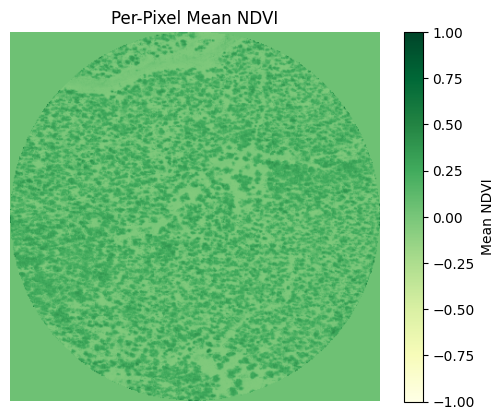

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Load one of the NDVI stat files
mean_ndvi = np.load("max_ndvi.npy")

# Basic stats
print("Shape:", mean_ndvi.shape)
print("Min:", np.min(mean_ndvi))
print("Max:", np.max(mean_ndvi))
print("Mean:", np.mean(mean_ndvi))

# Plot
plt.imshow(mean_ndvi, cmap='YlGn', vmin=-1, vmax=1)
plt.colorbar(label='Mean NDVI')
plt.title("Per-Pixel Mean NDVI")
plt.axis('off')
plt.show()

Pixel with max NDVI is at: (148, 80)
NDVI across years at that pixel: {2014: np.float64(0.14545453223140617), 2016: np.float64(0.02479338638071187), 2018: np.float64(0.6358133383307667), 2020: np.float64(0.15163313065096048), 2022: np.float64(0.07190051436579417)}


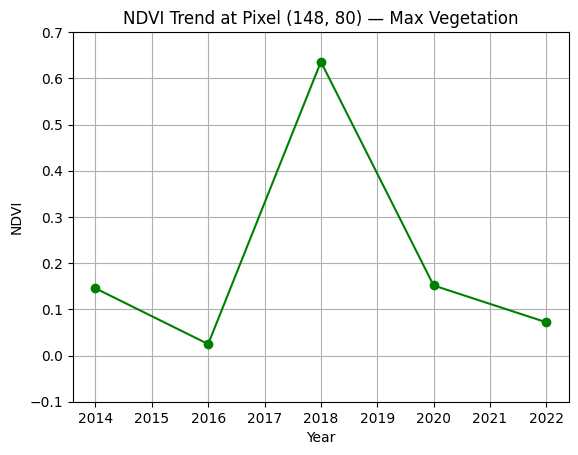

In [19]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Load max NDVI array
max_ndvi = np.load("max_ndvi.npy")

# Get the pixel with the max NDVI
row, col = np.unravel_index(np.argmax(max_ndvi), max_ndvi.shape)
print(f"Pixel with max NDVI is at: ({row}, {col})")

# Get NDVI across all years for that pixel
years = [2014, 2016, 2018, 2020, 2022]
ndvi_values = []

for year in years:
    if year <= 2016:
        path = f"preprocessed_output_{year}/matched_buffer_{year}.tif"
    else:
        path = f"preprocessed_output_{year}/coarsened_buffer_{year}.tif"

    with rasterio.open(path) as src:
        red = src.read(1)[row, col].astype(float)
        nir = src.read(4)[row, col].astype(float)
        ndvi = (nir - red) / (nir + red + 1e-5)
        ndvi_values.append(ndvi)

# Show NDVI trend over time
print("NDVI across years at that pixel:", dict(zip(years, ndvi_values)))

plt.plot(years, ndvi_values, marker='o', color='green')
plt.title(f"NDVI Trend at Pixel ({row}, {col}) — Max Vegetation")
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.grid(True)
plt.ylim(-0.1, 0.7)
plt.show()

In [40]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# The single pixel coordinates
row, col = 148, 80
years = [2014, 2016, 2018, 2020, 2022]

def get_path(year):

    return f"preprocessed_output_{year}/matched_buffer_{year}.tif"

pixels = []
for year in years:
    try:
        with rasterio.open(get_path(year)) as src:
            r = src.read(1)[row, col]
            g = src.read(2)[row, col]
            b = src.read(3)[row, col]
            pixels.append([r, g, b])
    except Exception as e:
        print(f"Skipping {year}: {e}")
        pixels.append([0, 0, 0])  # fallback to black

# Convert to image: shape (1 row, 5 cols, 3 channels)
pixels = np.array(pixels, dtype=np.float32)
pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min() + 1e-5)
image = np.reshape(pixels, (1, len(years), 3))

# Save to PNG
plt.imsave("pixel_148_80_RGB_timeline.png", image)

print("✅ Saved: pixel_148_80_RGB_timeline.png (1 row × 5 year pixels)")

✅ Saved: pixel_148_80_RGB_timeline.png (1 row × 5 year pixels)


### Advanced Sampling 

In [41]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
from PIL import Image

# --- CONFIG ---
output_dir = "labeled_samples_advanced"
os.makedirs(output_dir, exist_ok=True)

years = [2014, 2016, 2018, 2020, 2022]
ndvi_files = {
    "min": "min_ndvi.npy",
    "max": "max_ndvi.npy",
    "mean": "mean_ndvi.npy"
}
samples_per_category = 375  # ~1500 total
# ----------------

# Load NDVI stat arrays
min_ndvi = np.load(ndvi_files["min"])
max_ndvi = np.load(ndvi_files["max"])
mean_ndvi = np.load(ndvi_files["mean"])
rows, cols = min_ndvi.shape

# --- CATEGORY MASKS ---
high_mask = max_ndvi > 0.5
bare_mask = mean_ndvi < 0.1
transition_mask = (max_ndvi - min_ndvi) > 0.2
recovery_mask = (min_ndvi < 0.05) & (max_ndvi > 0.25)

# --- SAMPLING ---
def sample_mask(mask, count, taken):
    coords = np.argwhere(mask)
    np.random.shuffle(coords)
    samples = []
    for r, c in coords:
        key = (int(r), int(c))
        if key not in taken:
            samples.append(key)
            taken.add(key)
        if len(samples) >= count:
            break
    return samples

taken_pixels = set()
samples = []
samples += [(r, c, "HIGH") for r, c in sample_mask(high_mask, samples_per_category, taken_pixels)]
samples += [(r, c, "BARE") for r, c in sample_mask(bare_mask, samples_per_category, taken_pixels)]
samples += [(r, c, "TRANSITION") for r, c in sample_mask(transition_mask, samples_per_category, taken_pixels)]
samples += [(r, c, "RECOVERY") for r, c in sample_mask(recovery_mask, samples_per_category, taken_pixels)]

# --- PNG Helper ---
def save_pixel_png(rgb_bands, path, scale=64):
    rgb = np.array(rgb_bands, dtype=np.float32)
    rgb -= rgb.min()
    if rgb.max() > 0:
        rgb = rgb / rgb.max()
    rgb = (rgb * 255).astype(np.uint8)

    img = Image.fromarray(rgb.reshape(1, 1, 3), mode='RGB')
    img = img.resize((scale, scale), resample=Image.NEAREST)
    img.save(path)

# --- MAIN LOOP ---
records = []

for (r, c, category) in tqdm(samples, desc="Processing samples"):
    ndvi_values = {}
    for year in years:
        tif_path = f"preprocessed_output_{year}/matched_buffer_{year}.tif"
        fname = f"r{r}_c{c}_y{year}"
        png_path = os.path.join(output_dir, f"{fname}.png")
        tif_out_path = os.path.join(output_dir, f"{fname}.tif")

        try:
            with rasterio.open(tif_path) as src:
                # Extract pixel window
                pixel = src.read(window=((r, r+1), (c, c+1)))  # shape: [bands, 1, 1]
                rgb_bands = pixel[:3, 0, 0]

                # Save PNG
                save_pixel_png(rgb_bands, png_path)

                # Save TIF
                window = Window(c, r, 1, 1)
                transform = src.window_transform(window)
                meta = src.meta.copy()
                meta.update({"height": 1, "width": 1, "transform": transform})
                with rasterio.open(tif_out_path, "w", **meta) as dst:
                    dst.write(pixel)
        except Exception as e:  
            print(f"❌ {year} r{r} c{c} failed: {e}")
            ndvi_values[year] = np.nan
            continue

        # Compute NDVI
        try:
            with rasterio.open(tif_path) as src:
                red = src.read(1)[r, c]
                nir = src.read(4)[r, c]
                ndvi = (nir - red) / (nir + red + 1e-5)
                ndvi_values[year] = ndvi
        except:
            ndvi_values[year] = np.nan

    # Record metadata
    records.append({
        "row": r,
        "col": c,
        "category": category,
        "label": "",
        "ndvi_2014": ndvi_values.get(2014, np.nan),
        "ndvi_2016": ndvi_values.get(2016, np.nan),
        "ndvi_2018": ndvi_values.get(2018, np.nan),
        "ndvi_2020": ndvi_values.get(2020, np.nan),
        "ndvi_2022": ndvi_values.get(2022, np.nan),
        "min_ndvi": min_ndvi[r, c],
        "max_ndvi": max_ndvi[r, c],
        "mean_ndvi": mean_ndvi[r, c]
    })

# --- FLATTENED METADATA FORMAT ---
long_records = []
for rec in records:
    for year in years:
        filename = f"r{rec['row']}_c{rec['col']}_y{year}.png"
        long_records.append({
            "filename": filename,
            "row": rec["row"],
            "col": rec["col"],
            "year": year,
            "ndvi": rec.get(f"ndvi_{year}", np.nan),
            "label": ""
        })

# Save long-format metadata
df_long = pd.DataFrame(long_records)
df_long.to_csv(os.path.join(output_dir, "metadata.csv"), index=False)

# Save per-category CSVs
for cat in set(rec["category"] for rec in records):
    cat_rows = [r for r in records if r["category"] == cat]
    long_cat = []
    for rec in cat_rows:
        for year in years:
            filename = f"r{rec['row']}_c{rec['col']}_y{year}.png"
            long_cat.append({
                "filename": filename,
                "row": rec["row"],
                "col": rec["col"],
                "year": year,
                "ndvi": rec.get(f"ndvi_{year}", np.nan),
                "label": ""
            })
    pd.DataFrame(long_cat).to_csv(os.path.join(output_dir, f"metadata_{cat.lower()}.csv"), index=False)

print("✅ All PNGs, TIFs, and metadata saved to:", output_dir)

Processing samples:   0%|          | 0/1137 [00:00<?, ?it/s]/var/folders/5g/yd1vdsh57t939808t_l412f00000gn/T/ipykernel_10255/3147092517.py:104: RuntimeWarning: overflow encountered in scalar subtract
  ndvi = (nir - red) / (nir + red + 1e-5)
Processing samples: 100%|██████████| 1137/1137 [00:12<00:00, 89.78it/s]

✅ All PNGs, TIFs, and metadata saved to: labeled_samples_advanced


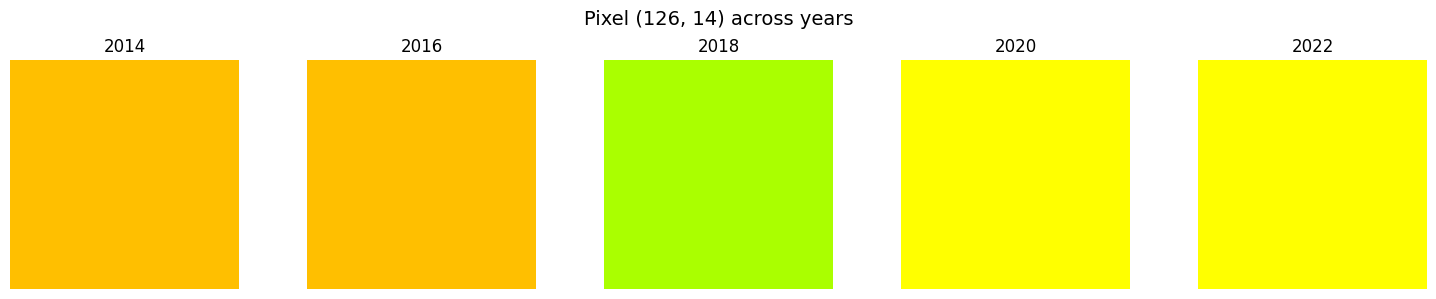

In [44]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Configuration
LABEL_FOLDER = "labeled_samples_advanced/"
YEARS = [2014, 2016, 2018, 2020, 2022]

def show_pixel_across_years(row, col):
    fig, axes = plt.subplots(1, len(YEARS), figsize=(15, 3))
    fig.suptitle(f"Pixel ({row}, {col}) across years", fontsize=14)

    for i, year in enumerate(YEARS):
        filename = f"r{row}_c{col}_y{year}.png"
        filepath = os.path.join(LABEL_FOLDER, filename)

        ax = axes[i]
        ax.axis('off')
        ax.set_title(f"{year}")

        if os.path.exists(filepath):
            img = Image.open(filepath)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=10)
            ax.set_facecolor("lightgray")

    plt.tight_layout()
    plt.show()


show_pixel_across_years(row=126, col=14)

In [46]:
import os
import numpy as np
from PIL import Image
import rasterio

# --- CONFIG ---
row = 397  # your pixel row
col = 73   # your pixel col
year = 2020  # choose a year to inspect
scale = 64  # size of output PNG
output_path = f"debug_pixel_r{row}_c{col}_y{year}.png"

tif_path = f"preprocessed_output_{year}/matched_buffer_{year}.tif"

def save_pixel_png(rgb_bands, path, scale=64):
    rgb = np.array(rgb_bands, dtype=np.float32)
    rgb -= rgb.min()
    if rgb.max() > 0:
        rgb = rgb / rgb.max()
    rgb = (rgb * 255).astype(np.uint8)

    img = Image.fromarray(rgb.reshape(1, 1, 3), mode='RGB')
    img = img.resize((scale, scale), resample=Image.NEAREST)
    img.save(path)
    print(f"✅ Saved PNG to: {path}")

# --- Extract and Save ---
with rasterio.open(tif_path) as src:
    rgb_bands = [
        src.read(1)[row, col],  # Red
        src.read(2)[row, col],  # Green
        src.read(3)[row, col]   # Blue
    ]
    print(rgb_bands)
    save_pixel_png(rgb_bands, output_path)

[np.uint16(0), np.uint16(0), np.uint16(0)]
✅ Saved PNG to: debug_pixel_r397_c73_y2020.png


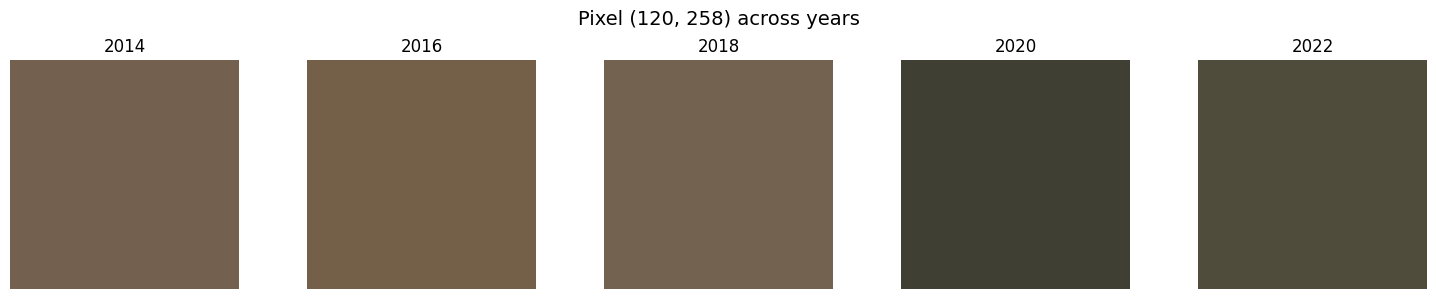

In [27]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Configuration
LABEL_FOLDER = "labeled_samples/"
YEARS = [2014, 2016, 2018, 2020, 2022]

def show_pixel_across_years(row, col):
    fig, axes = plt.subplots(1, len(YEARS), figsize=(15, 3))
    fig.suptitle(f"Pixel ({row}, {col}) across years", fontsize=14)

    for i, year in enumerate(YEARS):
        filename = f"r{row}_c{col}_y{year}.png"
        filepath = os.path.join(LABEL_FOLDER, filename)

        ax = axes[i]
        ax.axis('off')
        ax.set_title(f"{year}")

        if os.path.exists(filepath):
            img = Image.open(filepath)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center', fontsize=10)
            ax.set_facecolor("lightgray")

    plt.tight_layout()
    plt.show()

# Example usage
show_pixel_across_years(row=120, col=258)
